In [5]:
import xarray as xr
import hydromt  # noqa: F401
# hydromt.raster is needed for raster operations
import geopandas as gpd
import matplotlib.pyplot as plt
import os

import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from hydromt_wflow import WflowModel
import numpy as np
from matplotlib import colors

In [ ]:
# read, clip to the model extents and save as one file

all_years = []

for year in range(1990, 2023):
    path = fr"p:\wflow_global\intercomparison\gleam\42a\{year}\E_{year}_GLEAM_v4.2a.nc"
    ds = xr.open_dataset(path)
    ds = ds.raster.clip_bbox([28.5842, -14.3258, 29.6833, -13.2025])
    all_years.append(ds)

# Concatenate all years along the time dimension
combined_ds = xr.concat(all_years, dim="time")
out_dir = R"p:\11210554-dtc-hydrology-next\Mita_Hills\wflow\data"
combined_ds.to_netcdf(os.path.join(out_dir, "gleam_clipped_1990_2022.nc"))

In [2]:
ds = xr.open_dataset(R"p:\11210554-dtc-hydrology-next\Mita_Hills\wflow\MitaHills_latest\run_ff05_mf001_f_ksatRF_st5_pet15_chirps\output.nc")
ds_default_chirps = xr.open_dataset(R"p:\11210554-dtc-hydrology-next\Mita_Hills\wflow\MitaHills_latest\run_default_chrips_gridded_output\output.nc")
basin = gpd.read_file(R"p:\11210554-dtc-hydrology-next\Mita_Hills\wflow\MitaHills_latest\staticgeoms\basins.geojson")


ds_gleam = xr.open_dataset(R"p:\11210554-dtc-hydrology-next\Mita_Hills\wflow\data\gleam_clipped_1990_2022.nc")

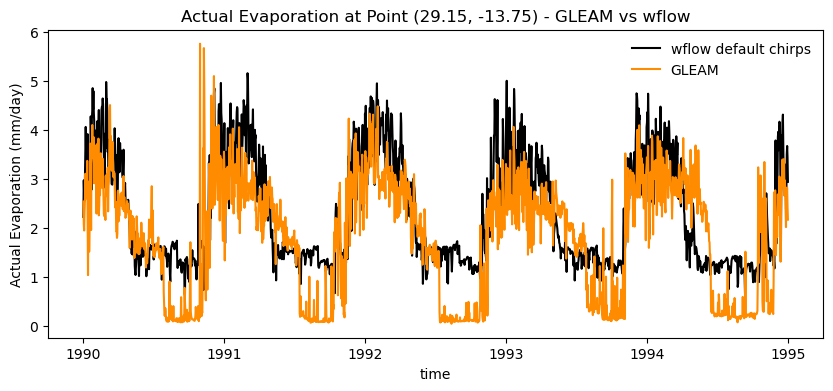

In [4]:
actevap_point_wflow_default_chirps = ds_default_chirps["actevap"].sel(lon=29.15, lat=-13.75, method="nearest")
actevap_timeseries_wflow_default_chirps = actevap_point_wflow_default_chirps.sel(time=slice("1990-01-02", "1994-12-31"))

actevap_point_gleam = ds_gleam["E"].sel(lon=29.15, lat=-13.75, method="nearest")
actevap_timeseries_gleam = actevap_point_gleam.sel(time=slice("1990-01-02", "1994-12-31"))

# Plot it
fig, ax = plt.subplots(figsize=(10, 4))
actevap_timeseries_wflow_default_chirps.plot(ax=ax, color="k", label="wflow default chirps")
actevap_timeseries_gleam.plot(ax=ax, color="darkorange", label="GLEAM")

ax.set_title("Actual Evaporation at Point (29.15, -13.75) - GLEAM vs wflow")
ax.legend(frameon=False)
ax.set_ylabel("Actual Evaporation (mm/day)");

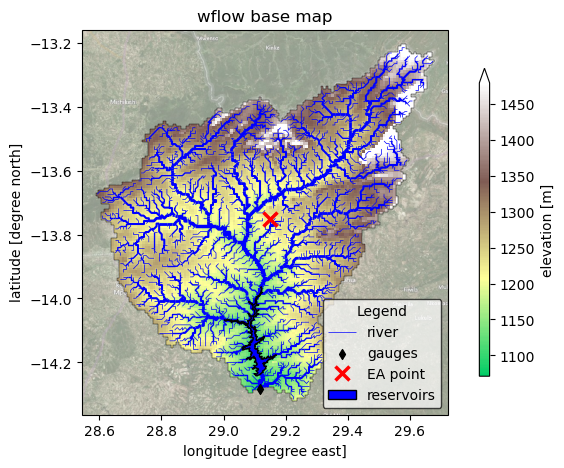

In [6]:
mod = WflowModel(root= R"p:\11210554-dtc-hydrology-next\Mita_Hills\wflow\MitaHills",
                mode="r"
                )
# read and mask the model elevation
da = mod.grid["wflow_dem"].raster.mask_nodata()
da.attrs.update(long_name="elevation", units="m")
# read/derive river geometries
gdf_riv = mod.rivers
# read/derive model basin boundary
gdf_bas = mod.basins

# we assume the model maps are in the geographic CRS EPSG:4326
proj = ccrs.PlateCarree()
# adjust zoomlevel and figure size to your basis size & aspect
zoom_level = 10
figsize = (8, 5)
shaded = False  # shaded elevation (looks nicer with more pixels (e.g.: larger basins))!

# initialize image with geoaxes
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection=proj)
bbox = da.raster.box.to_crs(3857).buffer(5e3).to_crs(da.raster.crs).total_bounds
extent = np.array(bbox)[[0, 2, 1, 3]]
ax.set_extent(extent, crs=proj)

# add sat background image
ax.add_image(cimgt.QuadtreeTiles(), zoom_level, alpha=0.5)

## plot elevation\
# create nice colormap
vmin, vmax = da.quantile([0.0, 0.98]).compute()
c_dem = plt.cm.terrain(np.linspace(0.25, 1, 256))
cmap = colors.LinearSegmentedColormap.from_list("dem", c_dem)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
kwargs = dict(cmap=cmap, norm=norm)
# plot 'normal' elevation
da.plot(
    transform=proj, ax=ax, zorder=1, cbar_kwargs=dict(aspect=30, shrink=0.8), **kwargs
)
# plot elevation with shades
if shaded:
    ls = colors.LightSource(azdeg=315, altdeg=45)
    dx, dy = da.raster.res
    _rgb = ls.shade(
        da.fillna(0).values,
        norm=kwargs["norm"],
        cmap=kwargs["cmap"],
        blend_mode="soft",
        dx=dx,
        dy=dy,
        vert_exag=200,
    )
    rgb = xr.DataArray(dims=("y", "x", "rgb"), data=_rgb, coords=da.raster.coords)
    rgb = xr.where(np.isnan(da), np.nan, rgb)
    rgb.plot.imshow(transform=proj, ax=ax, zorder=2)

# plot rivers with increasing width with stream order
gdf_riv.plot(
    ax=ax, linewidth=gdf_riv["strord"] / 2, color="blue", zorder=3, label="river"
)
# plot the basin boundary
gdf_bas.boundary.plot(ax=ax, color="k", linewidth=0.3)
# plot various vector layers if present
if "gauges" in mod.geoms:
    mod.geoms["gauges"].plot(
        ax=ax, marker="d", markersize=25, facecolor="k", zorder=5, label="gauges"
    )
patches = []  # manual patches for legend, see https://github.com/geopandas/geopandas/issues/660
if "lakes" in mod.geoms:
    kwargs = dict(facecolor="lightblue", edgecolor="black", linewidth=1, label="lakes")
    mod.geoms["lakes"].plot(ax=ax, zorder=4, **kwargs)
    patches.append(mpatches.Patch(**kwargs))
if "reservoirs" in mod.geoms:
    kwargs = dict(facecolor="blue", edgecolor="black", linewidth=1, label="reservoirs")
    mod.geoms["reservoirs"].plot(ax=ax, zorder=4, **kwargs)
    patches.append(mpatches.Patch(**kwargs))
if "glaciers" in mod.geoms:
    kwargs = dict(facecolor="grey", edgecolor="grey", linewidth=1, label="glaciers")
    mod.geoms["glaciers"].plot(ax=ax, zorder=4, **kwargs)
    patches.append(mpatches.Patch(**kwargs))

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_ylabel("latitude [degree north]")
ax.set_xlabel("longitude [degree east]")
_ = ax.set_title("wflow base map")


lon_pt = float(actevap_point_gleam.lon)
lat_pt = float(actevap_point_gleam.lat)

ax.plot(
    lon_pt,
    lat_pt,
    ls = ' ',
    marker='x',
    color='red',
    markersize=10,
    markeredgewidth=2.5,
    transform=proj,
    zorder=6,
    label='EA point'
)

legend = ax.legend(
    handles=[*ax.get_legend_handles_labels()[0], *patches],
    title="Legend",
    loc="lower right",
    frameon=True,
    framealpha=0.7,
    edgecolor="k",
    facecolor="white",
)

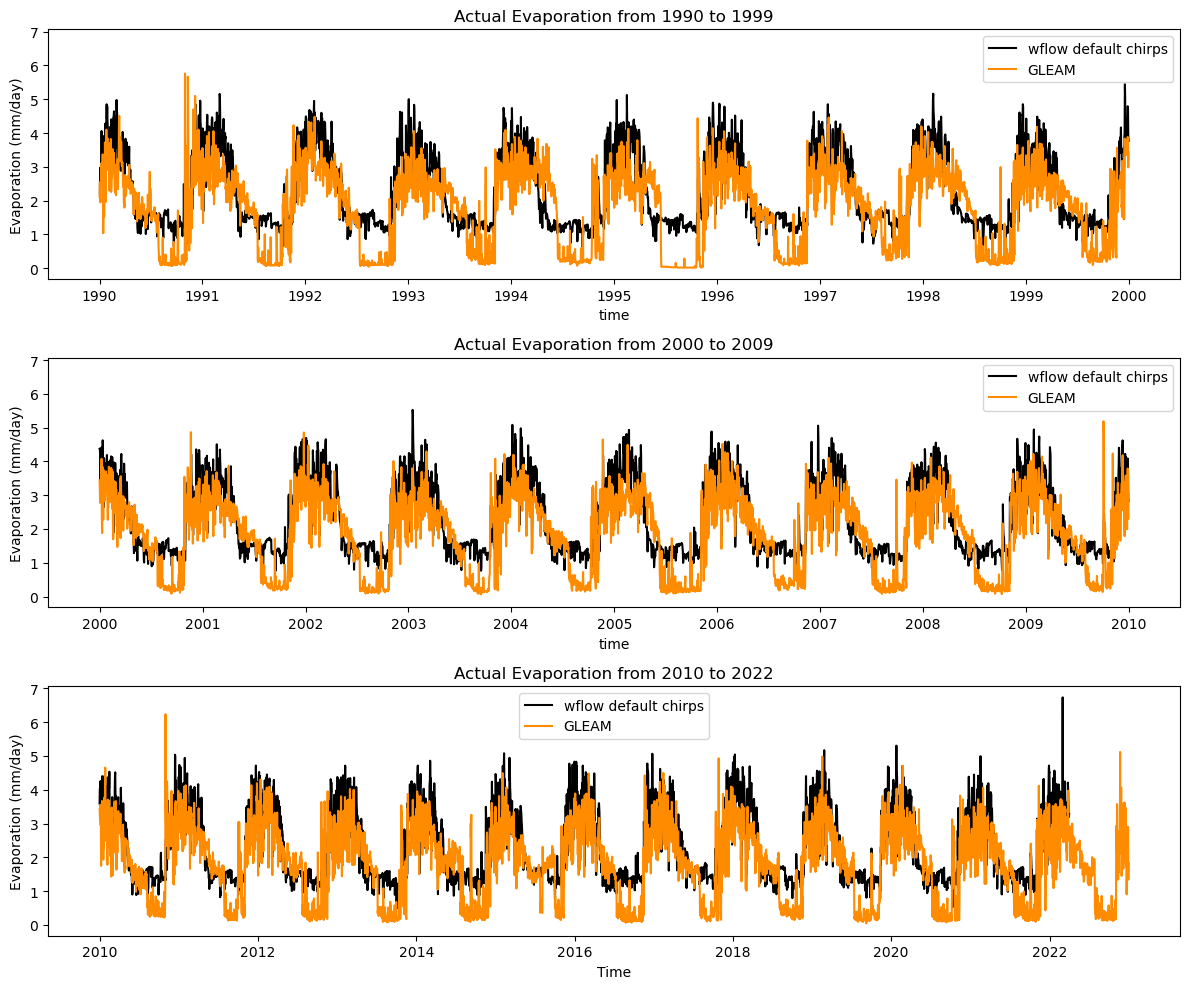

In [7]:
# Define your time slices
time_slices = [("1990-01-01", "1999-12-31"),
               ("2000-01-01", "2009-12-31"),
               ("2010-01-01", "2022-12-31")]

# Create figure and subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharey=True, sharex=False)

for ax, (start, end) in zip(axs, time_slices):
    # Slice data
    ts_wflow = actevap_point_wflow_default_chirps.sel(time=slice(start, end))
    ts_gleam = actevap_point_gleam.sel(time=slice(start, end))
    
    # Plot
    ts_wflow.plot(ax=ax, color="k", label="wflow default chirps")
    ts_gleam.plot(ax=ax, color="darkorange", label="GLEAM")
    
    ax.set_title(f"Actual Evaporation from {start[:4]} to {end[:4]}")
    ax.set_ylabel("Evaporation (mm/day)")
    ax.legend()

plt.xlabel("Time")
plt.tight_layout()
plt.show()

In [8]:
cp = ds_gleam.where(ds_gleam["E"].raster.geometry_mask(basin, all_touched =True))

monthly_mean_gleam = cp["E"].groupby("time.month").mean("time")
monthly_mean_wflow = ds["actevap"].sel(time=slice("1990-01-02", "2022-12-31")).groupby("time.month").mean("time")


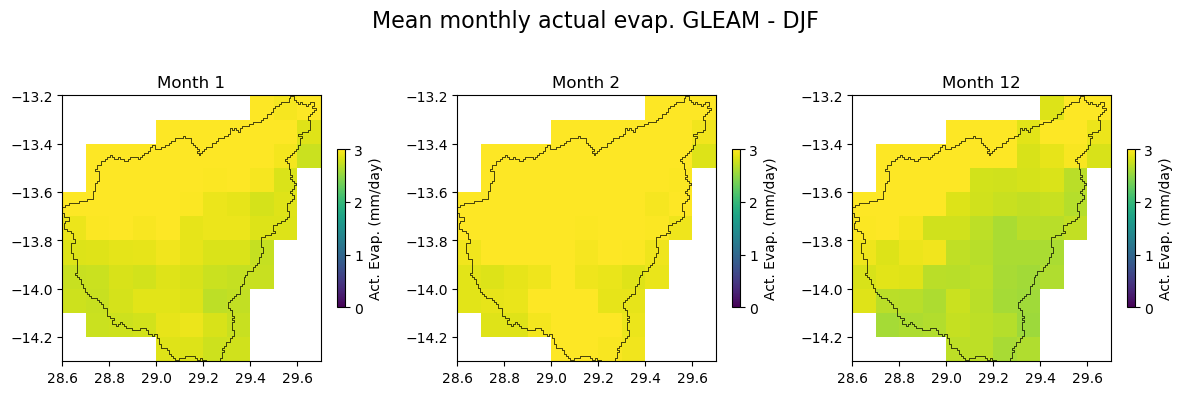

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axes = axes.flatten()

# Set overall title for the entire figure
fig.suptitle("Mean monthly actual evap. GLEAM - DJF", fontsize=16)

for idx, i in enumerate([1, 2, 12]):  
    # Plot GLEAM data without the colorbar
    im = monthly_mean_gleam[i-1].plot(ax=axes[idx], vmin=0, vmax=3, cmap="viridis", add_colorbar=False)
    basin.plot(ax=axes[idx], color="none", edgecolor="black", lw=0.5)
    
    # Set individual subplot titles (month as subtitle)
    axes[idx].set_title(f"Month {i}", fontsize=12)
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

    # Add colorbar with specific size and position
    cbar = fig.colorbar(im, ax=axes[idx], shrink=0.5)  # Adjust shrink parameter here
    cbar.set_label("Act. Evap. (mm/day)")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust to make room for the figure title
plt.show()


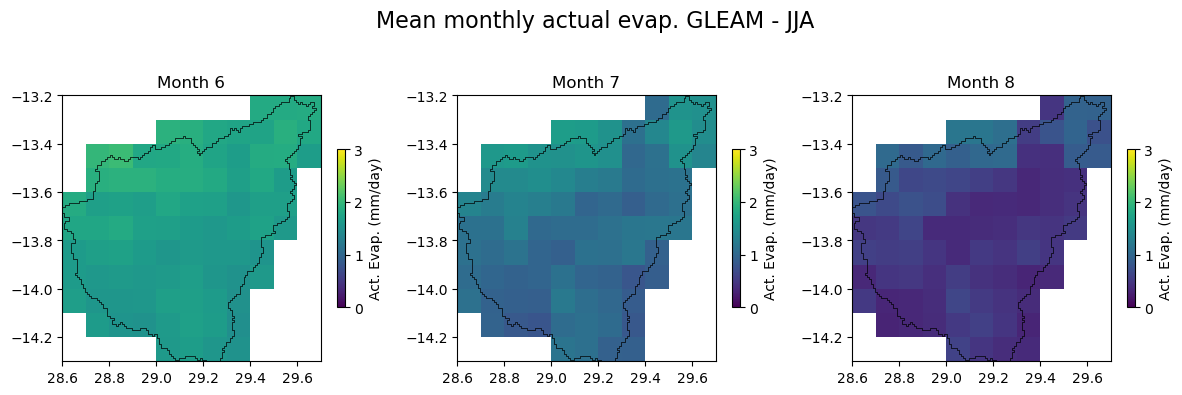

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axes = axes.flatten()

# Set overall title for the entire figure
fig.suptitle("Mean monthly actual evap. GLEAM - JJA", fontsize=16)

for idx, i in enumerate([6, 7, 8]):  # June, July, August
    # Plot GLEAM data without the colorbar
    im = monthly_mean_gleam[i-1].plot(ax=axes[idx], vmin=0, vmax=3, cmap="viridis", add_colorbar=False) # Adjust for zero-based indexing
    basin.plot(ax=axes[idx], color="none", edgecolor="black", lw=0.5)
    
    # Set individual subplot titles (month as subtitle)
    axes[idx].set_title(f"Month {i}", fontsize=12)
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

    # Add colorbar with specific size and position
    cbar = fig.colorbar(im, ax=axes[idx], shrink=0.5)  # Adjust shrink parameter here
    cbar.set_label("Act. Evap. (mm/day)")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust to make room for the figure title
plt.show()

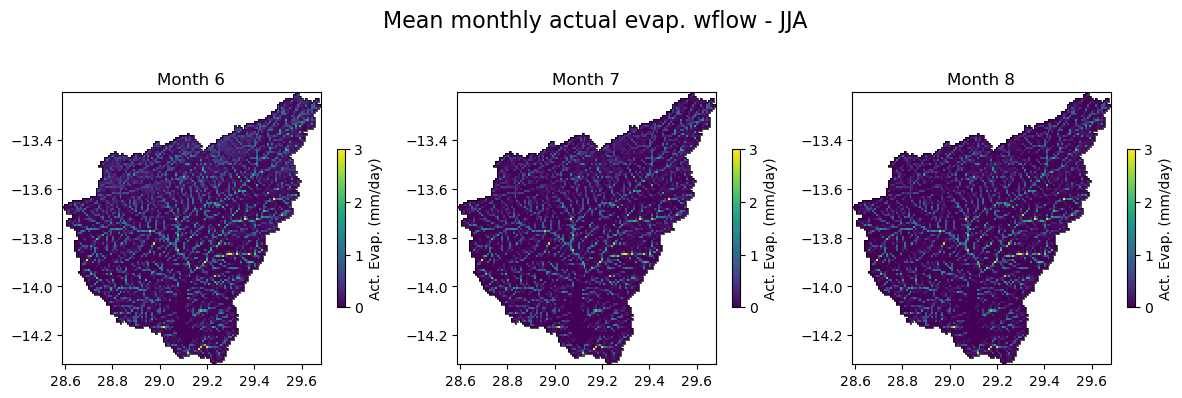

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axes = axes.flatten()

# Set overall title for the entire figure
fig.suptitle("Mean monthly actual evap. wflow - JJA", fontsize=16)

for idx, i in enumerate([6, 7, 8]): 
    # Plot GLEAM data without the colorbar
    im = monthly_mean_wflow[i-1].plot(ax=axes[idx], vmin=0, vmax=3, cmap="viridis", add_colorbar=False)
    basin.plot(ax=axes[idx], color="none", edgecolor="black", lw=0.5)
    
    # Set individual subplot titles (month as subtitle)
    axes[idx].set_title(f"Month {i}", fontsize=12)
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

    # Add colorbar with specific size and position
    cbar = fig.colorbar(im, ax=axes[idx], shrink=0.5)  # Adjust shrink parameter here
    cbar.set_label("Act. Evap. (mm/day)")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust to make room for the figure title
plt.show()

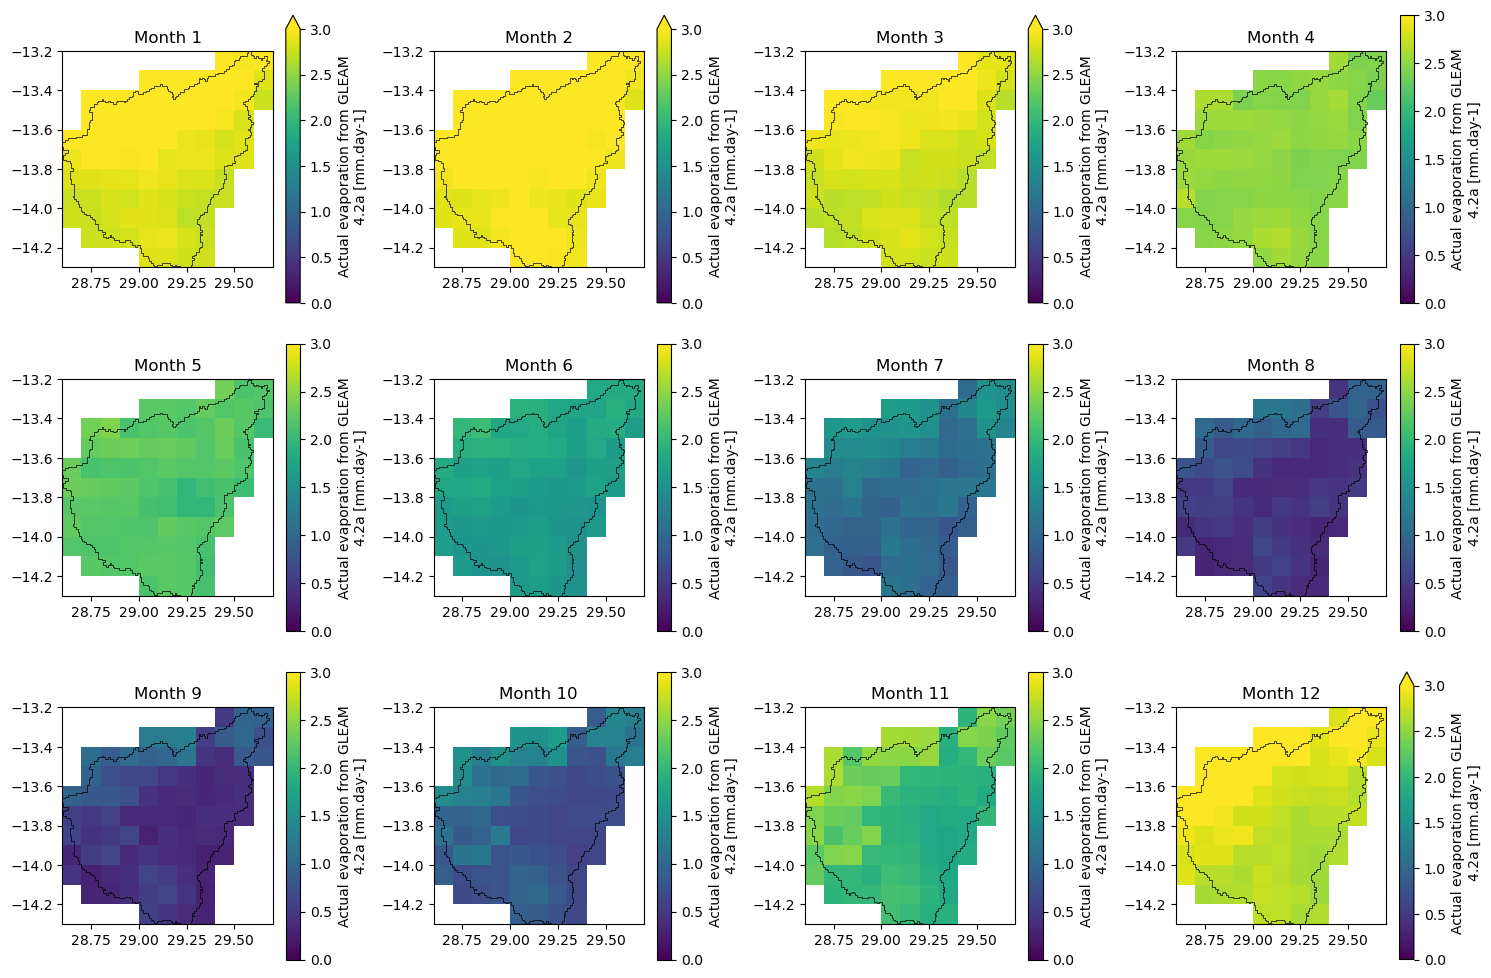

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
axes = axes.flatten()

for i in range(1, 13):
    ax = axes[i-1]
    monthly_mean_gleam.sel(month=i).plot(ax=ax, vmin=0, vmax=3, cmap="viridis")
    basin.plot(ax=ax, color="none", edgecolor="black", lw=0.5)
    ax.set_title(f"Month {i}")
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

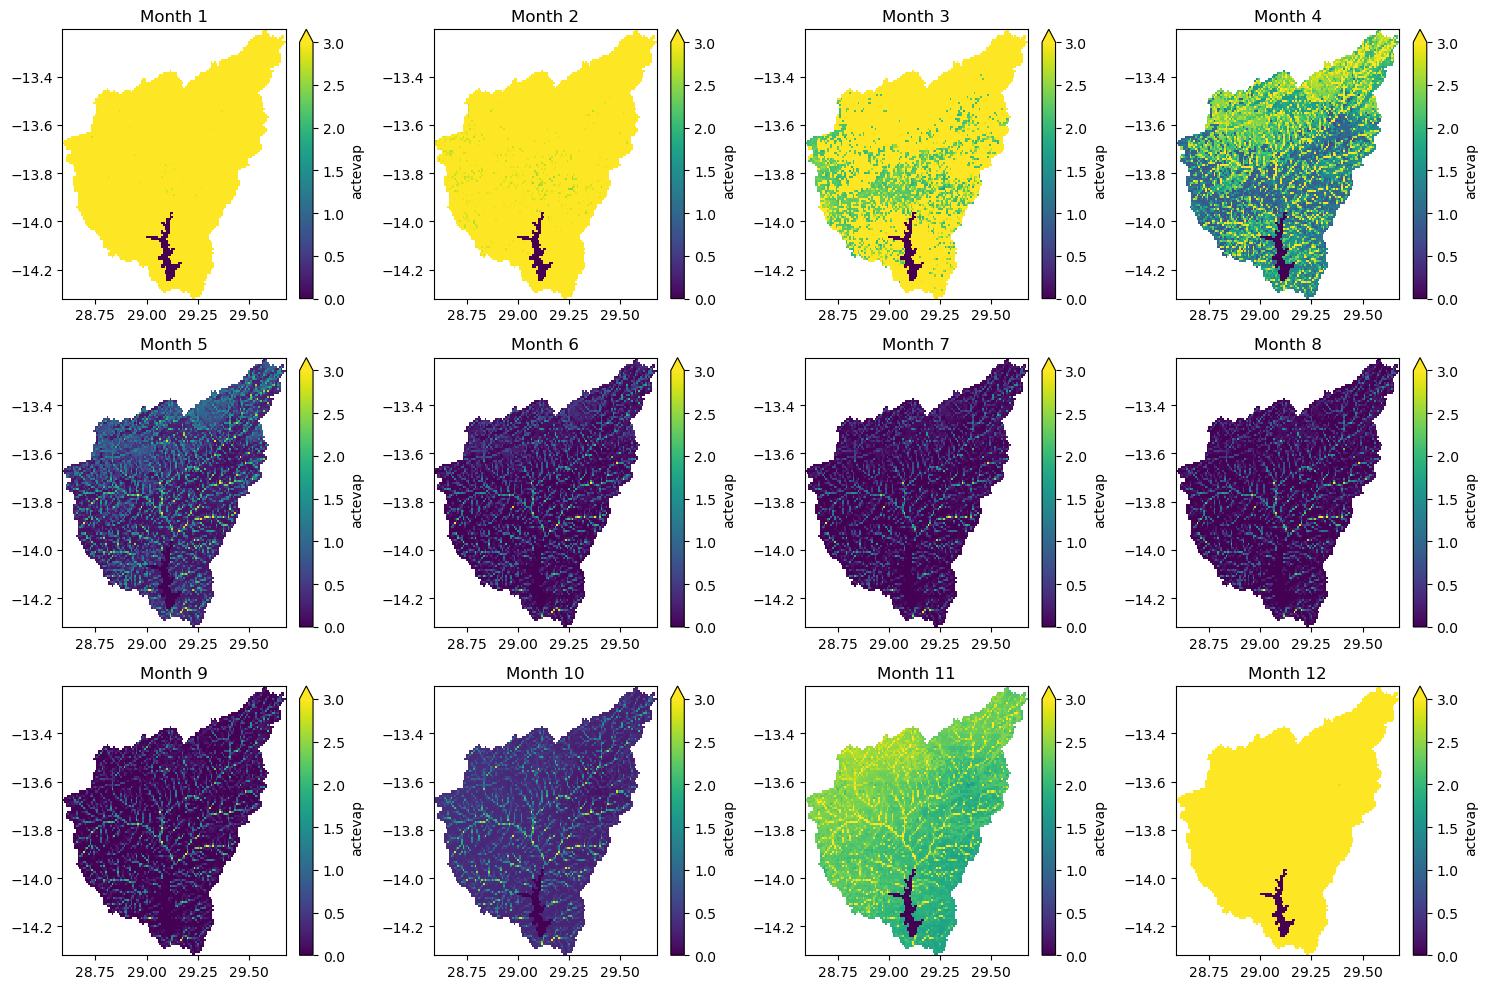

In [13]:
# Create subplots (3 rows x 4 columns = 12 months)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
axes = axes.flatten()

for i in range(1, 13):
    ax = axes[i-1]
    monthly_mean_wflow.sel(month=i).plot(ax=ax, vmin=0, vmax=3, cmap="viridis")
    ax.set_title(f"Month {i}")
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()